# PGS CTD Biota ADCP tutorial

⚠️ If the generated code snippets do not work, please open an issue https://issues.hubocean.earth/form/f57a63fa-20d2-4268-af79-41eca8f374cd 🙏

In [ ]:
!pip install -U odp-sdk --quiet && pip list | grep odp
!pip install -U pydeck --quiet && pip list | grep pydeck
!pip install -U matplotlib --quiet && pip list | grep matplotlib

## 1.1 Setup ODP Client

In [ ]:
from odp.client import OdpClient # The SDK

import pandas as pd
import pydeck as pdk
import matplotlib.pyplot as plt
from shapely.geometry import box, LineString, mapping
from helper_functions import convert_geometry_field, wkt_to_edges

### 1.1.2 Geometric Plot Helper

In [ ]:
# loading a simple function to make a nice map display of points
def simple_pydeck_plot(geojson_lists, size=1, lat=0, lon=0, zoom=2):
    colors = [(3, 255, 209), (255, 216, 11), (157, 89, 244), (254, 119, 76)]  # Cyan, Yellow, Purple, Orange
    layers = []
    for i, geojson_list in enumerate(geojson_lists):
        layer = pdk.Layer("GeoJsonLayer", data=convert_geometry_field(geojson_list), lineWidthMinPixels=size, pointRadiusMinPixels=size, pickable=True, get_line_color=colors[i % len(colors)], get_fill_color=colors[i % len(colors)],)
        layers.append(layer)
    r = pdk.Deck(layers=layers, initial_view_state=(pdk.ViewState(latitude=lat, longitude=lon, zoom=zoom)), map_provider="mapbox", map_style='mapbox://styles/oceandatafoundation/clwg6xklg00an01pcgmeufjxq', api_keys={'mapbox': 'pk.eyJ1Ijoib2NlYW5kYXRhZm91bmRhdGlvbiIsImEiOiJjazk5bGxpNWkwYWU1M2Vya3hkcHh4czdrIn0.yf7kIiPfDNE7KP9_9wTN6A'})
    return r

In [ ]:
client = OdpClient()

### 2.1 Fetch Metadata from Catalog
- Option 1) via API calls to the catalog
- Option 2) getting UUID from the landing page:
https://app.hubocean.earth/catalog/dataset/1e3401d4-9630-40cd-a9cf-d875cb310449-mammals_survey_concentrated
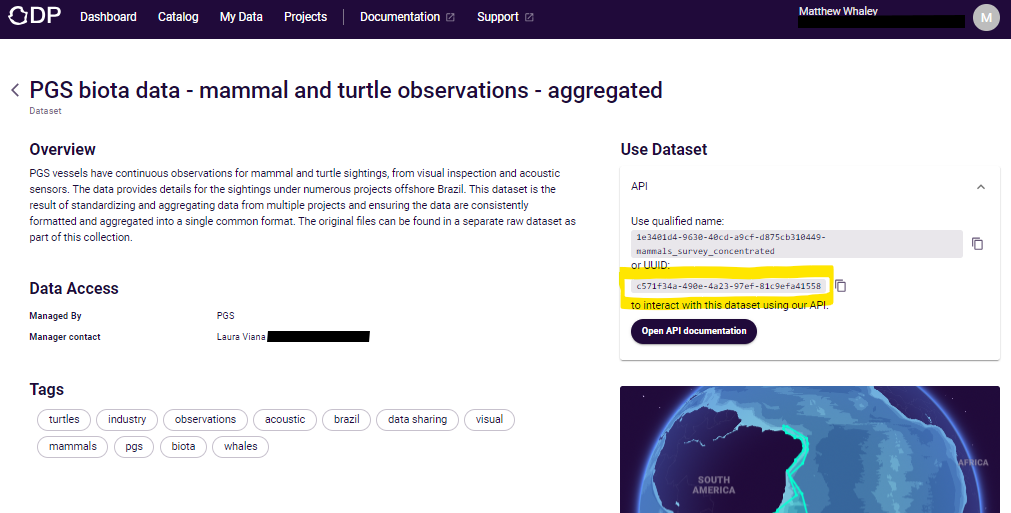

#### 2.2 Create a geospatial query
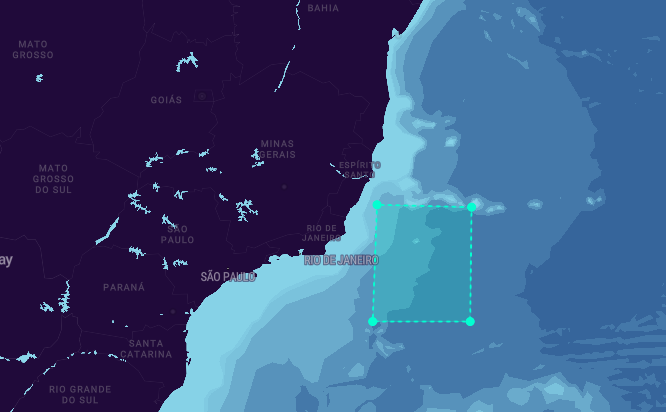

In [ ]:
bbox_lat_min = -26
bbox_lat_max = -21
bbox_lon_min = -40
bbox_lon_max = -35

geospatial_query = box(
    bbox_lon_min, bbox_lat_min,
    bbox_lon_max, bbox_lat_max
).wkt
bbox_list = wkt_to_edges(geospatial_query)

## 3.3 Fetch data


### 3.3.1 Fetch data with geospatial query

In [ ]:
ctd = client.catalog.get("67465006-8880-4a18-a867-f219c2c765fa")
print(ctd.metadata.display_name)

ctd_dataset = client.table_v2(ctd)

pages = list(
    ctd_dataset
      .select(f"geometry within '{geospatial_query}' AND Depth_m < 5")
      .pages()
)

CTD_data = [row for page in pages for row in page]

### 3.3.2 Fetch data with geospatial query

In [ ]:
biota = client.catalog.get("53697b8b-a570-48a4-b873-85dd0000fdd6")
print(biota.metadata.display_name)

biota_dataset = client.table_v2(biota)

pages = list(
    biota_dataset
      .select(f"geometry within '{geospatial_query}'")
      .pages()
)

biota_data = [row for page in pages for row in page]

## 4.1 Visualize data

### 4.1.1 Plot datapoints from queries on a map with bounding box

In [ ]:
simple_pydeck_plot([CTD_data, biota_data, bbox_list], zoom=6, lat=-23, lon=-39)

## 5.1 Inspect data
### 5.1.1 Option 1): work with list of datapoints

In [ ]:
#inspecting the fifth item of the list (numbering starts from 0)
biota_data[4:5]

### 5.1.2 Option 2): convert from the list to a pandas dataframe

In [ ]:
pd.DataFrame(biota_data).head()

### 5.1.3 Option 3): use 'select().dataframes()' function of the SDK

In [ ]:
df_geo = pd.concat(biota_dataset.select(f"geometry within '{geospatial_query}'").dataframes(), ignore_index=True)
df_geo.head()

## 6.1 Plot detailed CTD data

### 6.1.1 Geospatial query and get data directly to dataframe

In [ ]:
ctd_dataset = client.table_v2(ctd)

CTD_df = pd.concat(ctd_dataset.select(f"geometry within '{geospatial_query}'").dataframes(), ignore_index=True)

In [ ]:
CTD_df.head()

### 6.2 Plot data

In [ ]:
groupedCTD = CTD_df.groupby('ProfileName')
for name, group in groupedCTD:
    plt.plot(group['Temp_C'], group['Depth_m']*-1, label=name)
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (m)')
plt.title('Temperature vs. Depth Profiles')
plt.legend(fontsize='xx-small', loc='center left', bbox_to_anchor=(1, 0.5))  # Set the legend font size to 'small'
plt.show()